# Introduction

In this notebook, we’ll explore how to train a lightweight NanoGPT on the Tiny Stories dataset. NanoGPT, developed by Andrej Karpathy, is a simplified variant of GPT designed for simplicity and speed. Our goal is to generate creative and coherent text based on the input data. I will also use Wandb library to track the experiments on the model.

# Import Libraries

In [1]:
# Clone the NanoGPT
!git clone https://github.com/karpathy/nanoGPT.git
!pip3 install tiktoken

fatal: destination path 'nanoGPT' already exists and is not an empty directory.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.6/982.6 kB 8.6 MB/s eta 0:00:00


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import nanoGPT.model as GPT
import wandb
import os

In [12]:
# from kaggle_secrets import UserSecretsClient
# # Load API keys https://www.kaggle.com/discussions/product-feedback/114053
# secret_label = "WANDB_API_KEY"
my_secret = "c2e3619f245387906ce0bd58733dc79534a116bc"

In [15]:
class GPTConfig: # Model config from NanoGPT
    block_size: int = 256
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 14
    n_head: int = 8
    n_embd: int = 384
    dropout: float = 0.15
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

config = GPTConfig

In [16]:
wandb_config = {k:v for k,v in vars(config).items() if not callable(getattr(config, k)) and not k.startswith("__")} # Creating Wandb hyperparameters config for tracking experiements
wandb_config

{'block_size': 256,
 'vocab_size': 50304,
 'n_layer': 14,
 'n_head': 8,
 'n_embd': 384,
 'dropout': 0.15,
 'bias': True}

In [17]:
wandb.login(key=my_secret)

wandb: Currently logged in as: nisargbhavsar. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/abhay.inamdar/.netrc


True

# Tiny Stories datasets and preprocessing

TinyStories, a synthetic dataset of short stories that only contain words that a typical 3 to 4-year-olds usually understand, generated by GPT-3.5 and GPT-4. We show that TinyStories can be used to train and evaluate LMs that are much smaller than the state-of-the-art models (below 10 million total parameters)

In [18]:
!pip3 install datasets

In [21]:
!pip3 install sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.2 MB/s eta 0:00:00


In [19]:
import pandas as pd
df=pd.read_csv('/Users/malhar.inamdar/Desktop/task/tinystories_hindi_first_100000.csv')

In [22]:
import sentencepiece as spm

# Extract the text data from the 'story_translated' column, handling NaN values
texts = df['story_translated'].fillna("").astype(str).tolist()
# Preview the cleaned text data

print(texts[:5])  # Print the first 5 stories

['एक दिन, लिली नाम की एक छोटी लड़की को अपने कमरे में एक सुई मिली। वह जानती थी कि इससे खेलना मुश्किल है क्योंकि यह नुकीली थी। लिली अपनी माँ के साथ सुई बाँटना चाहती थी, ताकि वह अपनी शर्ट पर बटन लगा सके।\n\nलिली अपनी माँ के पास गई और बोली, "माँ, मुझे यह सुई मिली है। क्या तुम इसे मेरे साथ बाँट सकती हो और मेरी शर्ट सिल सकती हो?" उसकी माँ ने मुस्कुराते हुए कहा, "हाँ, लिली, हम सुई बाँट सकते हैं और तुम्हारी शर्ट ठीक कर सकते हैं।"\n\nसाथ मिलकर, उन्होंने सुई बाँट ली और लिली की शर्ट पर बटन लगा दिया। यह उनके लिए मुश्किल नहीं था क्योंकि वे एक-दूसरे की मदद कर रहे थे और बाँट रहे थे। काम पूरा करने के बाद, लिली ने अपनी माँ को सुई बाँटने और उसकी शर्ट ठीक करने के लिए धन्यवाद दिया। वे दोनों खुश थे क्योंकि उन्होंने एक-दूसरे की मदद की थी और एक-दूसरे की मदद की थी।', 'एक बार की बात है, बीप नाम की एक छोटी कार थी। बीप को तेज़ चलना और धूप में खेलना बहुत पसंद था। बीप एक स्वस्थ कार थी क्योंकि उसमें हमेशा अच्छा ईंधन होता था। अच्छा ईंधन बीप को खुश और मजबूत बनाता था।\n\nएक दिन, बीप पार्क में गाड़ी चला रहा था जब उसने 

In [23]:
# Train SentencePiece model if not already trained

if not os.path.exists("spm_model.model"):

    with open("hindi_corpus.txt", "w", encoding="utf-8") as f:

        for text in texts:

            f.write(text + "\n")

 

    # Train a SentencePiece model

    spm.SentencePieceTrainer.train(

        input='hindi_corpus.txt',

        model_prefix='spm_model',

        vocab_size=16000,  # Adjust vocab size as needed

        model_type='unigram'  # 'bpe', 'unigram', 'char', etc.

    )

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: hindi_corpus.txt
  input_format: 
  model_prefix: spm_model
  model_type: UNIGRAM
  vocab_size: 16000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
 

In [24]:
sp = spm.SentencePieceProcessor(model_file='spm_model.model')


In [25]:
# Function to tokenize data
def process(example):
    ids = sp.encode(example['text'], out_type=int)
    out = {'ids': ids, 'len': len(ids)}
    return out

In [26]:
# Create tokenized dataset files for training and validation
if not os.path.exists("train.bin"):
    tokenized = ds.map(
        process,
        remove_columns=['text'],
        desc="tokenizing the splits",
        num_proc=8,
    )

    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)
        filename = f'{split}.bin'
        dtype = np.uint16
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))

        idx = 0
        for batch_idx in tqdm(range(1024), desc=f'writing {filename}'):
            batch = dset.shard(num_shards=1024, index=batch_idx, contiguous=True).with_format('numpy')
            arr_batch = np.concatenate(batch['ids'])
            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()

In [30]:
# Training Configuration
learning_rate = 1e-4
max_iters = 25000
warmup_steps = 100
min_lr = 5e-4
eval_iters = 100
batch_size = 12
block_size = 128
gradient_accumulation_steps = 20

device = "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu'
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

In [31]:

# Define optimizer and scheduler
nanoGPT = GPT.GPT(config)
optimizer = torch.optim.AdamW(nanoGPT.parameters(), lr=learning_rate, betas=(0.9, 0.99), eps=1e-9)
from torch.optim.lr_scheduler import LinearLR, SequentialLR, CosineAnnealingLR

scheduler_warmup = LinearLR(optimizer, total_iters=warmup_steps)
scheduler_decay = CosineAnnealingLR(optimizer, T_max=max_iters - warmup_steps, eta_min=min_lr)
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps])

# Enable gradient scaling
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

number of parameters: 44.16M


/var/folders/n2/jc7_75cd545bk3h7m70jkr_r0000gn/T/ipykernel_12862/1865157901.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [32]:
# Initialize WandB
wandb.init(project="nanogpt-tinystories-hindi", name="nanoGPT-hindi-longer", config=wandb_config)

# Training loop
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        losses = estimate_loss(nanoGPT)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.4f}")
        train_loss_list.append(losses['train'])
        validation_loss_list.append(losses['val'])
        
        wandb.log({
            "epoch": epoch,
            "train/loss": losses['train'],
            "val/loss": losses['val'],
            "lr": optimizer.param_groups[0]['lr']
        })

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(nanoGPT.state_dict(), best_model_params_path)

    X, y = get_batch("train")
    with ctx:
        logits, loss = nanoGPT(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if (epoch + 1) % gradient_accumulation_steps == 0 or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(nanoGPT.parameters(), 1)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

wandb.finish()

epoch,▁▂▃▄▅▅▆▇█
lr,▁▁▁▂▃▄▅▆█
train/loss,█▇▆▅▄▃▃▂▁
val/loss,█▇▆▅▄▃▃▂▁
epoch,900
lr,0.0001
train/loss,8.79869
val/loss,8.79374


  0%|          | 0/25000 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 99/25000 [03:33<15:44:20,  2.28s/it]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainab

Epoch 100: train loss 9.7497, val loss 9.7606
The current learning rate: 0.0001


  1%|          | 200/25000 [10:13<16:37:22,  2.41s/it] 

Epoch 200: train loss 9.3569, val loss 9.3662
The current learning rate: 0.0001


  1%|          | 300/25000 [16:43<15:26:24,  2.25s/it] 

Epoch 300: train loss 9.0443, val loss 9.0487
The current learning rate: 0.0001


  2%|▏         | 400/25000 [22:57<17:19:08,  2.53s/it] 

Epoch 400: train loss 8.7077, val loss 8.7052
The current learning rate: 0.0001


  2%|▏         | 500/25000 [29:11<15:52:48,  2.33s/it] 

Epoch 500: train loss 8.3698, val loss 8.3825
The current learning rate: 0.0001


  2%|▏         | 600/25000 [35:07<15:22:37,  2.27s/it] 

Epoch 600: train loss 8.0411, val loss 8.0546
The current learning rate: 0.0001


  3%|▎         | 700/25000 [41:02<14:28:53,  2.15s/it] 

Epoch 700: train loss 7.7403, val loss 7.7426
The current learning rate: 0.0001


  3%|▎         | 800/25000 [46:45<15:14:29,  2.27s/it] 

Epoch 800: train loss 7.4356, val loss 7.4432
The current learning rate: 0.0001


  4%|▎         | 900/25000 [52:24<14:35:56,  2.18s/it] 

Epoch 900: train loss 7.1534, val loss 7.1539
The current learning rate: 0.0001


  4%|▍         | 1000/25000 [58:09<14:12:28,  2.13s/it]

Epoch 1000: train loss 6.8820, val loss 6.8725
The current learning rate: 0.0001


  4%|▍         | 1100/25000 [1:03:53<13:56:32,  2.10s/it] 

Epoch 1100: train loss 6.6275, val loss 6.6093
The current learning rate: 0.0001


  5%|▍         | 1200/25000 [1:09:45<14:27:47,  2.19s/it] 

Epoch 1200: train loss 6.3792, val loss 6.3906
The current learning rate: 0.0001


  5%|▌         | 1300/25000 [1:15:33<14:12:04,  2.16s/it] 

Epoch 1300: train loss 6.1813, val loss 6.1853
The current learning rate: 0.0001


  6%|▌         | 1400/25000 [1:21:19<13:49:37,  2.11s/it] 

Epoch 1400: train loss 5.9705, val loss 5.9788
The current learning rate: 0.0001


  6%|▌         | 1500/25000 [1:27:03<15:48:20,  2.42s/it] 

Epoch 1500: train loss 5.7868, val loss 5.7998
The current learning rate: 0.0001


  6%|▋         | 1600/25000 [1:32:50<13:53:52,  2.14s/it] 

Epoch 1600: train loss 5.6449, val loss 5.6313
The current learning rate: 0.0001


  7%|▋         | 1700/25000 [1:38:36<13:41:42,  2.12s/it] 

Epoch 1700: train loss 5.5131, val loss 5.5068
The current learning rate: 0.0001


  7%|▋         | 1800/25000 [1:44:24<14:02:08,  2.18s/it] 

Epoch 1800: train loss 5.3782, val loss 5.3722
The current learning rate: 0.0001


  8%|▊         | 1900/25000 [1:50:13<13:27:06,  2.10s/it] 

Epoch 1900: train loss 5.2451, val loss 5.2476
The current learning rate: 0.0001


  8%|▊         | 2000/25000 [1:56:00<13:29:52,  2.11s/it] 

Epoch 2000: train loss 5.1318, val loss 5.1286
The current learning rate: 0.0001


  8%|▊         | 2100/25000 [2:01:44<13:18:59,  2.09s/it] 

Epoch 2100: train loss 5.0360, val loss 5.0478
The current learning rate: 0.0001


  9%|▉         | 2200/25000 [2:07:30<13:39:16,  2.16s/it] 

Epoch 2200: train loss 4.9510, val loss 4.9588
The current learning rate: 0.0001


  9%|▉         | 2300/25000 [2:13:21<13:20:48,  2.12s/it] 

Epoch 2300: train loss 4.8901, val loss 4.8618
The current learning rate: 0.0001


 10%|▉         | 2400/25000 [2:19:26<19:31:26,  3.11s/it] 

Epoch 2400: train loss 4.8061, val loss 4.8173
The current learning rate: 0.0001


 10%|█         | 2500/25000 [2:25:21<13:06:43,  2.10s/it] 

Epoch 2500: train loss 4.7374, val loss 4.7333
The current learning rate: 0.0001


 10%|█         | 2600/25000 [2:31:02<13:03:20,  2.10s/it] 

Epoch 2600: train loss 4.6716, val loss 4.6626
The current learning rate: 0.0001


 11%|█         | 2700/25000 [2:36:46<12:52:49,  2.08s/it] 

Epoch 2700: train loss 4.6026, val loss 4.6129
The current learning rate: 0.0001


 11%|█         | 2800/25000 [2:42:29<12:53:40,  2.09s/it] 

Epoch 2800: train loss 4.5546, val loss 4.5701
The current learning rate: 0.0001


 12%|█▏        | 2900/25000 [2:48:25<14:23:54,  2.35s/it] 

Epoch 2900: train loss 4.5252, val loss 4.5226
The current learning rate: 0.0001


 12%|█▏        | 3000/25000 [2:54:26<13:13:21,  2.16s/it] 

Epoch 3000: train loss 4.4493, val loss 4.4472
The current learning rate: 0.0001


 12%|█▏        | 3100/25000 [3:00:13<13:26:02,  2.21s/it] 

Epoch 3100: train loss 4.4332, val loss 4.4265
The current learning rate: 0.0001


 13%|█▎        | 3200/25000 [3:06:15<13:28:17,  2.22s/it] 

Epoch 3200: train loss 4.3525, val loss 4.3561
The current learning rate: 0.0001


 13%|█▎        | 3300/25000 [3:12:19<13:38:23,  2.26s/it] 

Epoch 3300: train loss 4.3269, val loss 4.3262
The current learning rate: 0.0001


 14%|█▎        | 3400/25000 [3:18:26<13:27:52,  2.24s/it] 

Epoch 3400: train loss 4.2940, val loss 4.2805
The current learning rate: 0.0001


 14%|█▍        | 3500/25000 [3:24:35<13:18:08,  2.23s/it] 

Epoch 3500: train loss 4.2419, val loss 4.2621
The current learning rate: 0.0001


 14%|█▍        | 3600/25000 [3:30:44<14:20:55,  2.41s/it] 

Epoch 3600: train loss 4.2109, val loss 4.2450
The current learning rate: 0.0001


 15%|█▍        | 3700/25000 [3:36:30<12:21:26,  2.09s/it] 

Epoch 3700: train loss 4.1647, val loss 4.1776
The current learning rate: 0.0001


 15%|█▌        | 3800/25000 [3:42:15<12:18:57,  2.09s/it] 

Epoch 3800: train loss 4.1510, val loss 4.1239
The current learning rate: 0.0001


 16%|█▌        | 3900/25000 [3:47:58<12:15:00,  2.09s/it] 

Epoch 3900: train loss 4.0923, val loss 4.0976
The current learning rate: 0.0001


 16%|█▌        | 4000/25000 [3:53:41<12:13:08,  2.09s/it] 

Epoch 4000: train loss 4.0993, val loss 4.0923
The current learning rate: 0.0001


 16%|█▋        | 4100/25000 [3:59:22<12:10:43,  2.10s/it] 

Epoch 4100: train loss 4.0263, val loss 4.0456
The current learning rate: 0.0001


 17%|█▋        | 4200/25000 [4:05:03<12:05:24,  2.09s/it] 

Epoch 4200: train loss 4.0246, val loss 4.0175
The current learning rate: 0.0001


 17%|█▋        | 4300/25000 [4:10:46<12:01:51,  2.09s/it] 

Epoch 4300: train loss 3.9903, val loss 3.9819
The current learning rate: 0.0001


 18%|█▊        | 4400/25000 [4:16:26<11:54:13,  2.08s/it] 

Epoch 4400: train loss 3.9465, val loss 3.9711
The current learning rate: 0.0001


 18%|█▊        | 4500/25000 [4:22:06<11:55:36,  2.09s/it] 

Epoch 4500: train loss 3.9444, val loss 3.9284
The current learning rate: 0.0001


 18%|█▊        | 4600/25000 [4:27:49<11:53:50,  2.10s/it] 

Epoch 4600: train loss 3.9238, val loss 3.8947
The current learning rate: 0.0001


 19%|█▉        | 4700/25000 [4:33:30<11:50:19,  2.10s/it] 

Epoch 4700: train loss 3.8880, val loss 3.8731
The current learning rate: 0.0001


 19%|█▉        | 4800/25000 [4:39:15<11:49:39,  2.11s/it] 

Epoch 4800: train loss 3.8406, val loss 3.8843
The current learning rate: 0.0001


 19%|█▉        | 4862/25000 [4:43:45<19:35:20,  3.50s/it] 


KeyboardInterrupt: 

Matplotlib is building the font cache; this may take a moment.


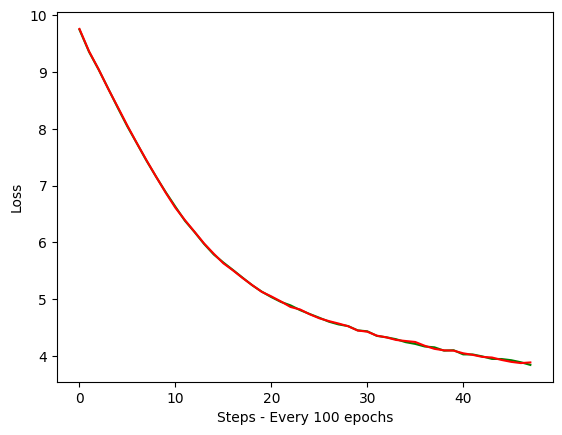

In [34]:
# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot([i.cpu().detach() for i in train_loss_list], 'g', [i.cpu().detach() for i in validation_loss_list], 'r')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.show()

In [35]:
# Load the best model
nanoGPT = GPT.GPT(config)
nanoGPT.load_state_dict(torch.load(best_model_params_path, map_location=device))


number of parameters: 44.16M


/var/folders/n2/jc7_75cd545bk3h7m70jkr_r0000gn/T/ipykernel_12862/2112017095.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nanoGPT.load_state_dict(torch.load(best_model

<All keys matched successfully>

In [40]:
# Assuming the SentencePiece EOS token is available; define its ID manually (use the actual ID if known).
eos_token_id = sp.piece_to_id("</s>")  # or use an ID if you have a specific EOS token

def generate_with_sampling(model, context, max_tokens, temperature=1.0, top_k=None, top_p=None, eos_token_id=None):
    model.eval()
    generated_tokens = context

    for _ in range(max_tokens):
        # Get the model's prediction logits
        with torch.no_grad():
            logits, _ = model(generated_tokens[:, -model.config.block_size:])
            logits = logits[:, -1, :]  # Focus on last token logits only
            logits = logits / temperature  # Apply temperature

            # Top-K sampling
            if top_k is not None:
                top_k_values, top_k_indices = torch.topk(logits, top_k)
                logits[logits < top_k_values[:, [-1]]] = -float('Inf')  # Mask logits outside top-k

            # Top-P (nucleus) sampling
            if top_p is not None:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(torch.nn.functional.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_logits[cumulative_probs > top_p] = -float('Inf')
                logits = torch.scatter(logits, dim=-1, index=sorted_indices, src=sorted_logits)

            # Apply softmax to get probabilities and sample from the distribution
            probs = torch.nn.functional.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
        
        # Append the predicted token to the generated sequence
        generated_tokens = torch.cat((generated_tokens, next_token), dim=1)

        # Break if EOS token is generated
        if eos_token_id is not None and next_token.item() == eos_token_id:
            break

    return generated_tokens

In [41]:
# Usage
sentence = "एक समय की बात है जब एक कद्दू था।"
context = torch.tensor(sp.encode(sentence, out_type=int)).unsqueeze(0).to(device)
output_tokens = generate_with_sampling(nanoGPT, context, max_tokens=200, temperature=0.8, top_k=50, top_p=0.9, eos_token_id=eos_token_id)
print(sp.decode(output_tokens.squeeze().tolist()))


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [37]:
sentence = "एक समय की बात है जब एक कद्दू था।"
context = torch.tensor(sp.encode(sentence, out_type=int)).unsqueeze(0).to(device)
y = nanoGPT.generate(context, 200)
y_clipped = torch.clamp(y, min=0, max=sp.vocab_size() - 1)
print(sp.decode(y_clipped.squeeze().tolist()))

एक समय की बात है जब एक कद्दू था। ने गर्व गर्व सुनाऊंगीारत ⁇  व्यवहार तुम्हारा को कहतेऔ ब चित्र लियो लेती को कहतेऔ फूटाकारी गर्व गर्व किताब जागत दिखाई तुम्हारा को ⁇ औ तैयार खोए ने जूते अग आनंद मैदान दिल छड़ी होता दिखाई पढ़ा ने जीव चले करो मिले देखना एवोकाडोऔ मज़ेदारस्टोर नरमऔ दिखाईऔ लूसी को दिल बनाना ने करवाया फलों याद हँसते को पाकर तैयार याद हिस्साचांदऔऔ दूसरे हँसते मज़ेदार मिलने बनाता सहेली चिप्स खिलाता तस्वीरें लूसी उधार छीलन उम्मीद डरा कूदना बैगपेड़ समुद्र पीने मज़ेदारदूसरेऔ याद खजानााँ बांबी चमकाए ने जगह गर्व गर्व किताबऔऔ तालाब जेक अभी लंबी नाई डरा भागते बदलती उठाया थूका शेर याद अभिभावक लूसीदूसरे घटा सड़ेऔ लूसीदूसरेऔ ने दूसर तैयार्स गिर याद हिस्सा यूनि दिखाई पत्नी मज़ेदार ब्लूई बुझात दिखाई बाघ बनाना तैयाराँग होताऔमाल सके दुखेंगे ने लियो सीढ़ी पिछवाड़औ ने लियो तैयार तैरऔ स्ट्रॉबेरी इंतज साझाऔमाल याद हिस्सा शिल्प ने गर्व गर्व ब्रोकली उम्मीद शेर याद खजाना दिखाईबापथर्मामीटर मौज याद भरवा इंद्रधनुष नाची तैयार बोतलमाल याद खजाना कूदतीमाल याद नीले ने व्यवहार बकजीब्बीामकनमस्ते


# Training

In [10]:
# Some functions from https://github.com/karpathy/nanoGPT/blob/master/train.py with slight modifications
def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

In [12]:
# Training Config

learning_rate = 1e-4
max_iters = 25000
warmup_steps = 100
min_lr = 5e-4
eval_iters = 100
batch_size = 12
block_size = 64

gradient_accumulation_steps = 50

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

In [13]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

nanoGPT = GPT.GPT(config)
optimizer =  torch.optim.AdamW(nanoGPT.parameters(), lr=learning_rate, betas=(0.9, 0.99), eps=1e-9)

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

number of parameters: 40.61M


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [14]:
wandb.init(project="nanogpt-tinystories", name="nanoGPT-sml-longer", config=wandb_config)

best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

for epoch in tqdm(range(max_iters)):
    if epoch%eval_iters == 0 and epoch != 0:
        losses = estimate_loss(nanoGPT)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.4f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        wandb.log({
                "epoch": epoch,
                "train/loss": losses['train'],
                "val/loss": losses['val'],
                "lr": optimizer.param_groups[0]['lr']
            })

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(nanoGPT.state_dict(), best_model_params_path)

    X,y = get_batch("train")

    with ctx:
        logits, loss = nanoGPT(X, y)
        loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(nanoGPT.parameters(), 1)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()


wandb.finish()

  0%|          | 0/25000 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  0%|          | 99/25000 [02:09<7:38:52,  1.11s/it] /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is dif

Epoch 100: train loss 10.0016, val loss 10.0150
The current learning rate: 0.0001


  0%|          | 117/25000 [03:38<12:53:51,  1.87s/it] 


KeyboardInterrupt: 

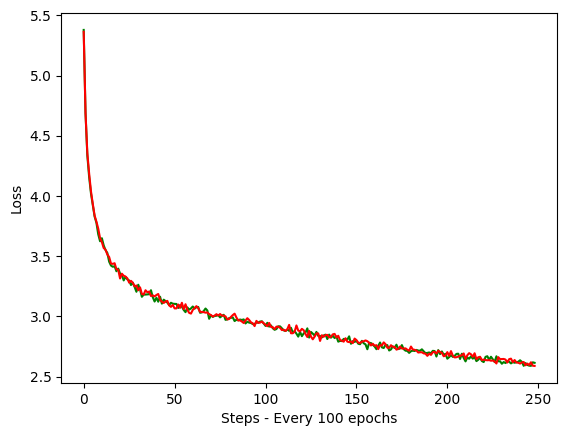

In [ ]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]
plt.plot(train_loss_list_converted, 'g', validation_loss_list_converted, 'r')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.show()

# Inference

In [ ]:
#Load the model
nanoGPT = GPT.GPT(config)
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
nanoGPT.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states


number of parameters: 40.61M


<ipython-input-15-d4e888674873>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nanoGPT.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device)

<All keys matched successfully>

In [ ]:
sentence = "Once upon a time there was a pumpkin."
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = nanoGPT.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Once upon a time there was a pumpkin. It was a very special pumpkin, it could speak. It was sad because it couldn’t move. Every day, it would say thank you to the pumpkin to a nice place where it was.



In [ ]:
from google.colab import runtime
runtime.unassign()